# Build a model

` Notes`

- ` Using XGBoost; Random FOrest, LightGBM `
- ` Explore CrossValidation apart from sklearn.cross_validation ` 
- ` `


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
# Transforming categorical features for train data
lbl = preprocessing.LabelEncoder()

#models
import xgboost as xgb


C:\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv("input/train.csv")
train_df = train_df.drop(['product_type'], axis=1)
print ("Train data shape: ", train_df.shape)
test_df = pd.read_csv("input/test.csv")
test_df = test_df.drop(['product_type'], axis=1)
print("Test data shape: ",test_df.shape)

Train data shape:  (30471, 291)
Test data shape:  (7662, 290)


In [3]:
# Data preprocessing and creating of test-train split of TRAIN DATA

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        lbl.fit(train_df[col].values)
        train_df[col] = lbl.transform(train_df[col].values)
    else:
        train_df[col] = np.log1p(train_df[col])
        
# Training data test-train set preparation 
train_y = train_df.price_doc.values
train_X = train_df.drop(['id', 'timestamp','price_doc'],axis=1)

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape))
print ("Testing set has {} samples.".format(X_test.shape))

Training set has (24376, 288) samples.
Testing set has (6095, 288) samples.


In [4]:
# Data preprocessing and creating of test-train split of TEST DATA

#Preparing test data
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        
        lbl.fit(test_df[col].values)
        test_df[col] = lbl.transform(test_df[col].values)
    else:
        test_df[col] = np.log1p(test_df[col])
            
        
test_X = test_df.drop(['id', 'timestamp'], axis=1)
id_test = test_df['id']
#Show the results
print("Test data set has {} samples".format(test_X.shape))       

Test data set has (7662, 288) samples


In [5]:
df_columns = train_X.columns

dtrain_all = xgb.DMatrix(train_X, train_y,feature_names=df_columns)
dtrain = xgb.DMatrix(X_train, y_train,feature_names=df_columns)
dval = xgb.DMatrix(X_test, y_test,feature_names=df_columns)
dtest = xgb.DMatrix(test_X, feature_names=df_columns)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	val-rmse:14.3696
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:5.17593
[40]	val-rmse:1.91247
[60]	val-rmse:0.817175
[80]	val-rmse:0.526811
[100]	val-rmse:0.474455
[120]	val-rmse:0.465917
[140]	val-rmse:0.464064
[160]	val-rmse:0.463383
[180]	val-rmse:0.46321
[200]	val-rmse:0.463046
[220]	val-rmse:0.462777
[240]	val-rmse:0.46237
[260]	val-rmse:0.462151
[280]	val-rmse:0.462143
Stopping. Best iteration:
[264]	val-rmse:0.462077



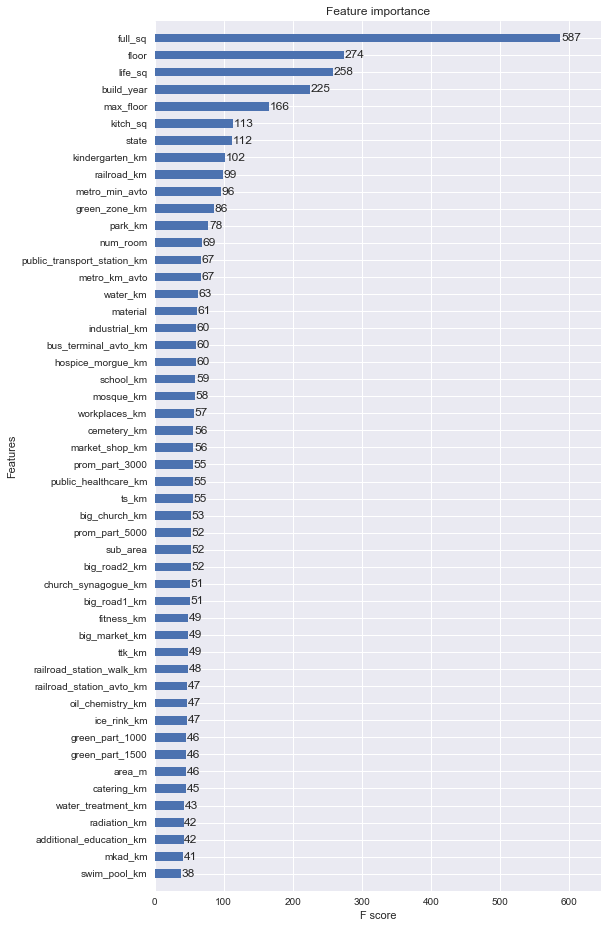

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(partial_model, max_num_features=50, height=0.5, ax=ax)
plt.show()

In [7]:
num_boost_round = partial_model.best_iteration

In [8]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round)

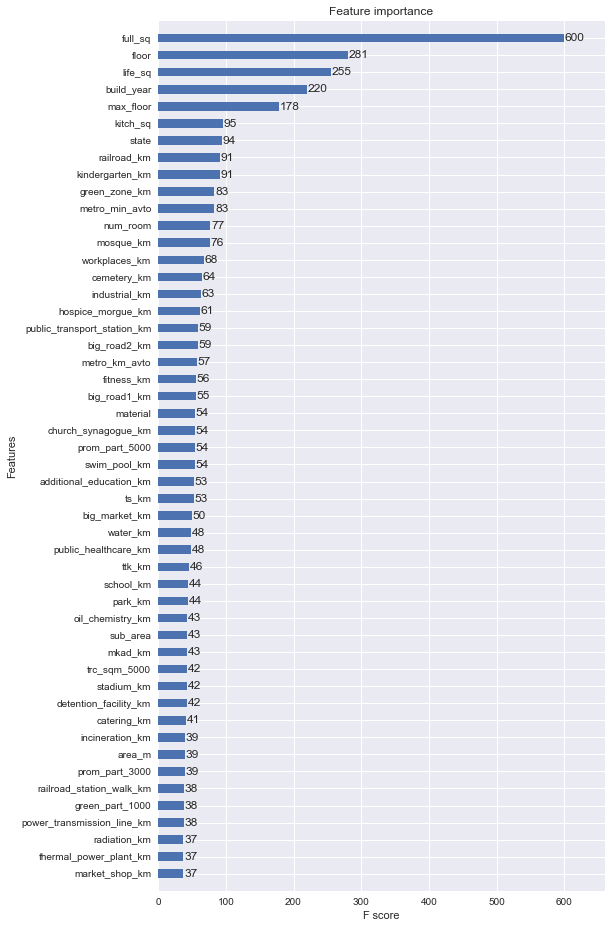

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)
plt.show()

In [13]:
ylog_pred = model.predict(dtest)
y_pred = np.exp(ylog_pred) - 1
id_test = np.exp(id_test) - 1

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('sub_20170712.csv', index=False)